# **Load Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_curve, auc, RocCurveDisplay
import optuna
import torch

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
df_train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [5]:
df_train.shape

(140700, 20)

In [6]:
df_train.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

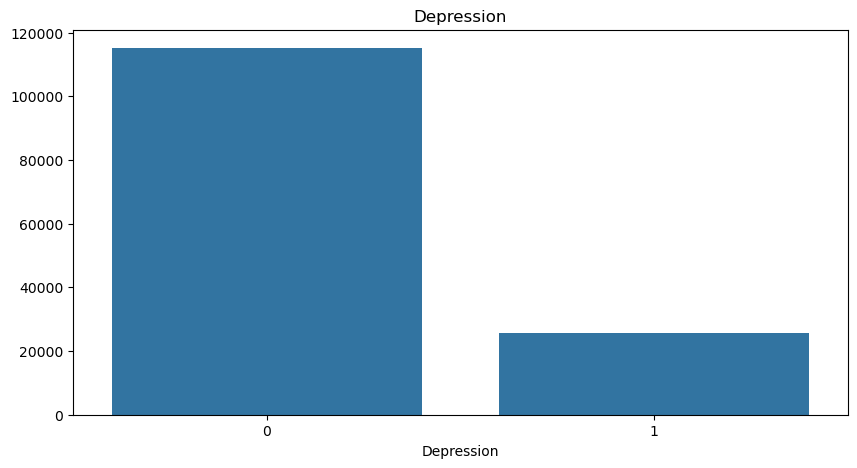

In [7]:
plt.figure(figsize=(10, 5))
uni_count = df_train['Depression'].value_counts()
sns.barplot(x=uni_count.index, y=uni_count.values)
plt.title(f"Depression")
plt.show()

# **Missing Data Handling**

In [8]:
num_columns = df_train.select_dtypes(include=['float64','int64']).columns
cat_columns = df_train.select_dtypes(include='object').columns

## **Filling Missing Values in Numeric Columns**

For Academic Pressure, CGPA, Study Satisfaction, Work Pressure and Job Satisfaction columns only

In [9]:
df_train[num_columns].isnull().sum()

id                         0
Age                        0
Academic Pressure     112803
Work Pressure          27918
CGPA                  112802
Study Satisfaction    112803
Job Satisfaction       27910
Work/Study Hours           0
Financial Stress           4
Depression                 0
dtype: int64

In [10]:
def fillna_num(df):
    columns = ['Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction']
    for column in columns:
        df[column] = df[column].fillna(-1) # Filled with -1
    return df

df_train = fillna_num(df_train)
df_test = fillna_num(df_test)

For Financial Stress Column

In [11]:
df_train['Financial Stress'].value_counts()

Financial Stress
2.0    31451
5.0    28279
4.0    27765
1.0    27211
3.0    25990
Name: count, dtype: int64

In [12]:
df_train['Financial Stress'] = df_train['Financial Stress'].fillna(float(df_train['Financial Stress'].median())) # Filled with Median of the data in respected column
df_test['Financial Stress'] = df_test['Financial Stress'].fillna(float(df_test['Financial Stress'].median()))

In [13]:
df_train[num_columns].isnull().sum()

id                    0
Age                   0
Academic Pressure     0
Work Pressure         0
CGPA                  0
Study Satisfaction    0
Job Satisfaction      0
Work/Study Hours      0
Financial Stress      0
Depression            0
dtype: int64

All numerical missing values are filled.

In [14]:
df_train[num_columns].describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000
mean,70349.500000,40.388621,-0.178699,2.205508,0.716835,-0.217825,2.186020,6.252679,2.988984,0.181713
std,40616.735775,12.384099,1.762205,2.031656,3.513295,1.685430,2.029611,3.853615,1.413613,0.385609
min,0.000000,18.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,-1.000000,2.000000,-1.000000,-1.000000,2.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,-1.000000,4.000000,-1.000000,-1.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


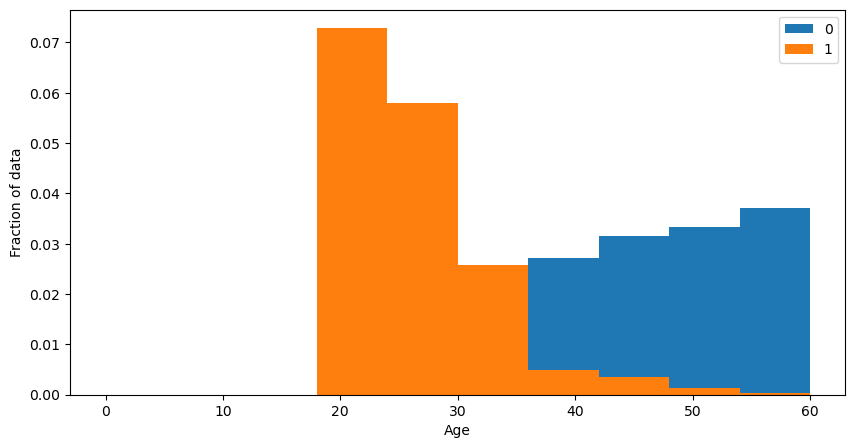

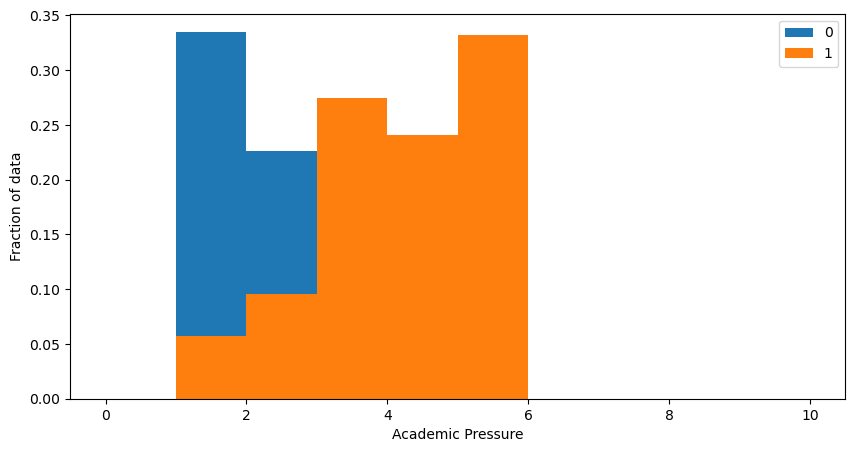

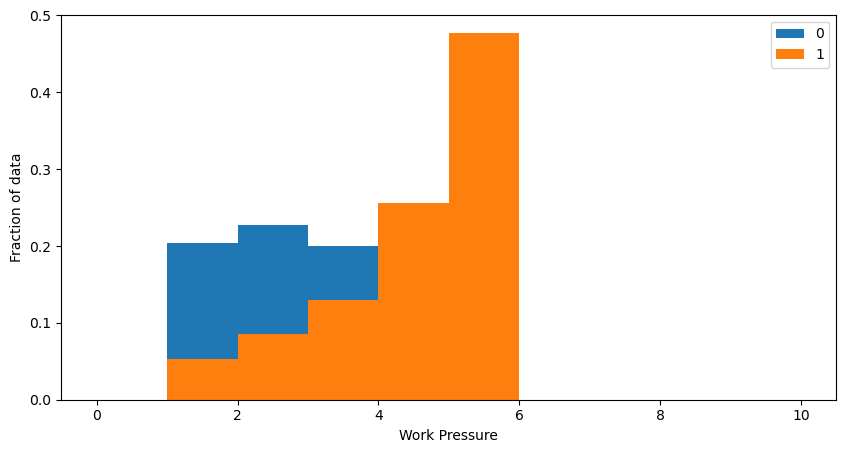

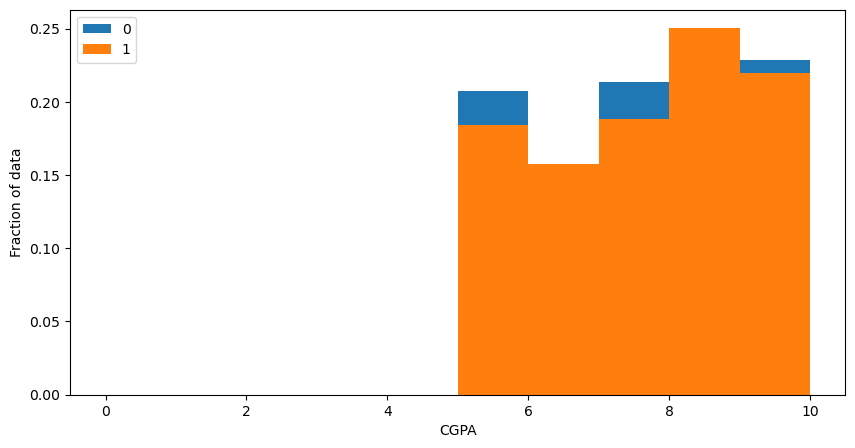

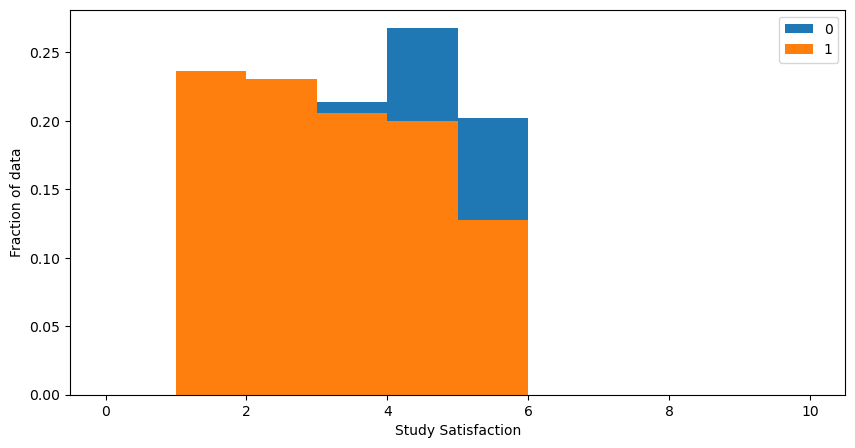

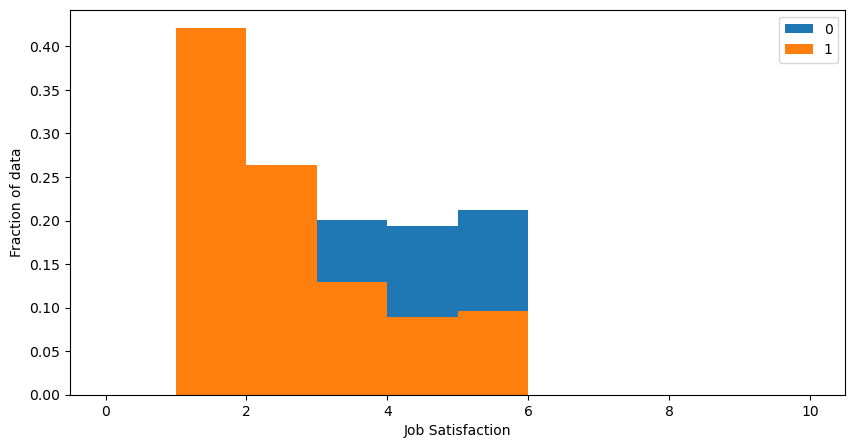

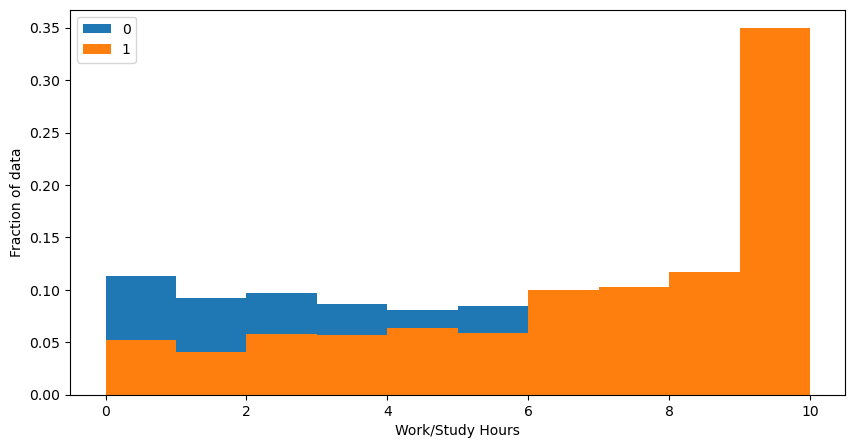

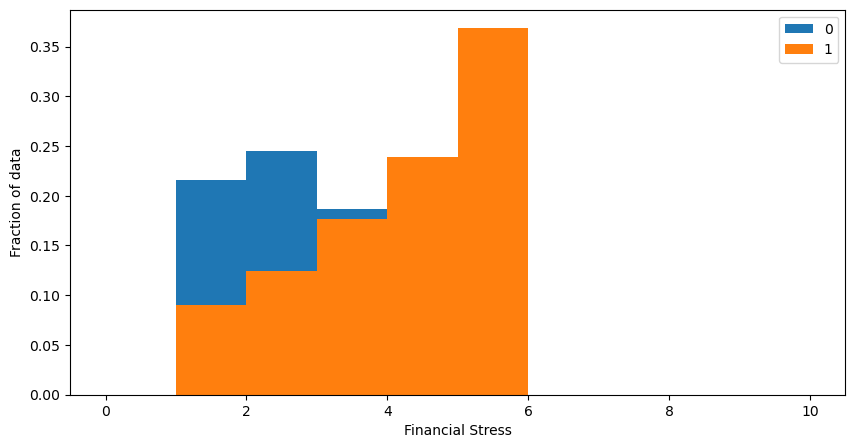

In [15]:
def make_hist(df):
    num_columns = df.select_dtypes(include='float64').columns
    for column in num_columns:
        pvalue = df[df['Depression']== 0][column].to_numpy()
        evalue = df[df['Depression']== 1][column].to_numpy()
        fig, ax = plt.subplots(figsize=(10,5))
        plot_range = [0,10]
        if column == 'Age':
            plot_range = [0,60]
        ax.hist(pvalue, bins=10, range=plot_range, density=True, label='0')
        ax.hist(evalue, bins=10, range=plot_range, density=True, label='1')
        ax.legend()
        ax.set_xlabel(f'{column}')
        ax.set_ylabel('Fraction of data')
        plt.show()

make_hist(df_train)

## **Filling Missing Values in Categorical Column** 

In [16]:
df_train[cat_columns].isnull().sum()

Name                                         0
Gender                                       0
City                                         0
Working Professional or Student              0
Profession                               36630
Sleep Duration                               0
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
Family History of Mental Illness             0
dtype: int64

In [17]:
sub_cat_columns = ['Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
for column in sub_cat_columns:
    print('.............................')
    print(df_train[column].value_counts())

.............................
Profession
Teacher           24906
Content Writer     7814
Architect          4370
Consultant         4229
HR Manager         4022
                  ...  
BBA                   1
City Manager          1
FamilyVirar           1
B.Com                 1
Yuvraj                1
Name: count, Length: 64, dtype: int64
.............................
Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours  

In [18]:
# The missing values are filled with 'Other'

def fillna_cat(df):
    columns = ['Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']
    for column in columns:
        df[column].fillna('other', inplace=True)
    return df

df_train = fillna_cat(df_train)
df_test = fillna_cat(df_test)

/var/folders/3c/r_lgphm557b3vln2970f1yth0000gn/T/ipykernel_1259/2222590251.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna('other', inplace=True)


In [19]:
def fill_less_frequent_value(df):
    columns = ['Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']
    for column in columns:
        count = df[column].value_counts()
        less_freq = count[count<20].index
        df[column] = df[column].apply(lambda x: 'other' if x in less_freq else x)
    return df

df_train = fill_less_frequent_value(df_train)
df_test = fill_less_frequent_value(df_test)

## **Checking Everything Okay**

In [20]:
df_train[cat_columns].isnull().sum()

Name                                     0
Gender                                   0
City                                     0
Working Professional or Student          0
Profession                               0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Family History of Mental Illness         0
dtype: int64

In [21]:
sub_cat_columns = ['Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
for column in sub_cat_columns:
    print('.............................')
    print(df_train[column].value_counts())

.............................
Profession
other                     36680
Teacher                   24906
Content Writer             7814
Architect                  4370
Consultant                 4229
HR Manager                 4022
Pharmacist                 3893
Doctor                     3255
Business Analyst           3161
Entrepreneur               2968
Chemist                    2967
Chef                       2862
Educational Consultant     2852
Data Scientist             2390
Researcher                 2328
Lawyer                     2212
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1737
Judge                      1712
Electrician                1582
Financial Analyst          1574
Software Engineer          1510
Civil Engineer             1470
UX/UI Designer             1452
Digital Marketer           1372

All missing values are filled up.

# **Encoding**

In [22]:
def encoding(df):
    cat_columns = df.select_dtypes(include='object').columns
    
    encoder = OrdinalEncoder()
    df[cat_columns] = encoder.fit_transform(df[cat_columns].astype(str))
    
    return df

df_train = encoding(df_train)
df_test = encoding(df_test)

## **Correlation Matrix**

/var/folders/3c/r_lgphm557b3vln2970f1yth0000gn/T/ipykernel_1259/355035135.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr[np.argsort(corr,axis=0)[::-1]]


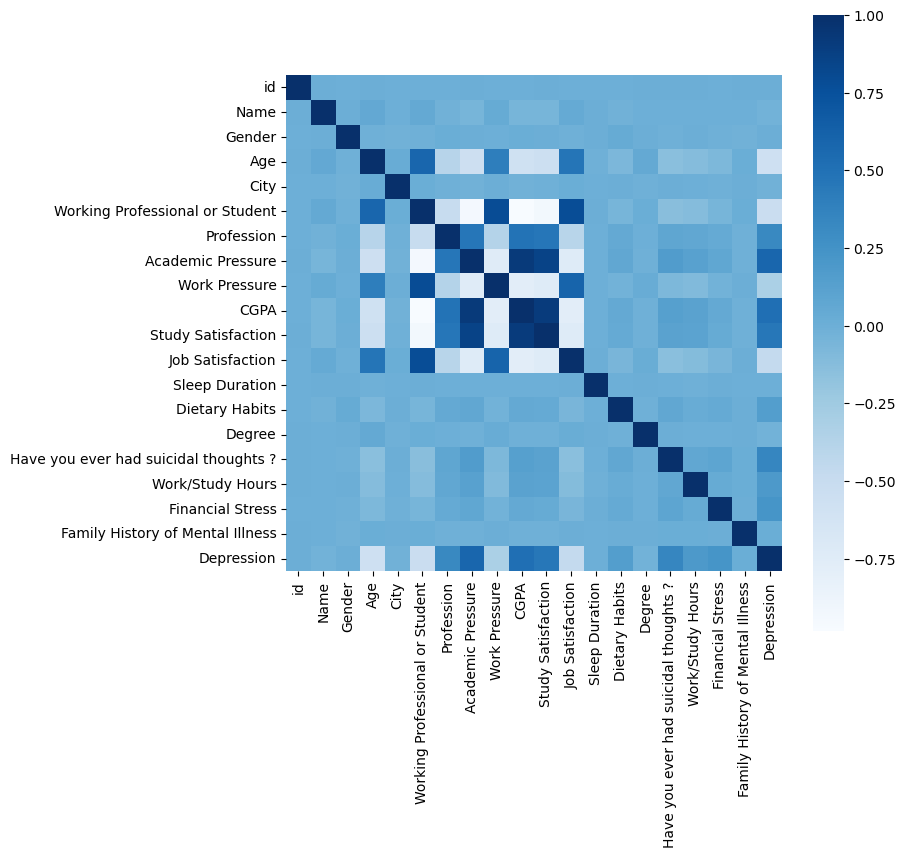

In [23]:
corr=df_train.corr()['Depression']
corr[np.argsort(corr,axis=0)[::-1]]

features_correlation = df_train.corr()
plt.figure(figsize=(8,8))
sns.heatmap(features_correlation,vmax=1,square=True,annot=False,cmap='Blues')
plt.show()

# **Stacking Ensemble**


I developed a stacking ensemble model that includes four base models (Random Forest, SVM, K-Nearest Neighbors, and Decision Tree) and a logistic regression meta-model.

In [24]:
X = df_train.drop(['id', 'Name', 'City', 'Depression'], axis=1)
X_test = df_test.drop(['id', 'Name', 'City'], axis=1)
y = df_train['Depression']

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## **Defining Base Models**

In [26]:
base_models = [
    ('random_forest', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('svm', make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))),
    ('knn', KNeighborsClassifier(n_neighbors=10)),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
]

## **Defining Meta Model**

In [27]:
meta_model = LogisticRegression(random_state=42)

## **Create Stacking Model**

In [28]:
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=10
)

In [29]:
X = df_train.drop(columns=['Depression'])
y = df_train['Depression']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('random_forest',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('svm',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('svc',
                                                 SVC(probability=True,
                                                     random_state=42))])),
                               ('knn', KNeighborsClassifier(n_neighbors=10)),
                               ('decision_tree',
                                DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [31]:
y_pred = stacking_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy of Stacking Ensemble Model:", accuracy)

Validation Accuracy of Stacking Ensemble Model: 0.9364960909737029


In [32]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     22986
           1       0.85      0.79      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.94      0.94      0.94     28140



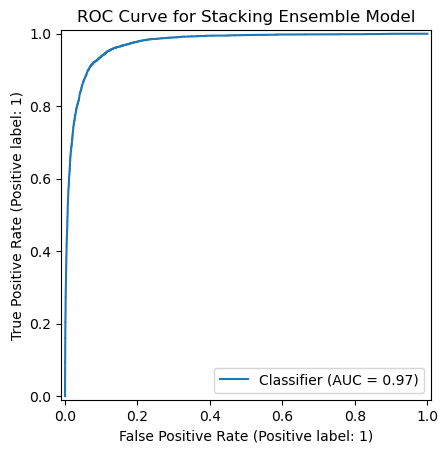

In [33]:
y_pred_prob = stacking_model.predict_proba(X_val)[:, 1]
RocCurveDisplay.from_predictions(y_val, y_pred_prob)
plt.title("ROC Curve for Stacking Ensemble Model")
plt.show()